In [1]:
from IPython.core.display import HTML
with open ("../style.css", "r") as file:
    css = file.read()
HTML(css)

# Automatic Differentiation with `autograd`

This is a short introduction to the library `autograd`.
Technically, `autograd` wraps and extends `numpy`.  It is most often imported as follows:

In [2]:
import autograd       as ag
import autograd.numpy as np

In order to plot the functions that we are going to differentiate, we also import `matplotlib` and `seaborn`.

In [3]:
import matplotlib.pyplot as plt
import seaborn           as sns

We start with a trivial example and take the derivative of the function
$$ f(x) = x \cdot \exp(x). $$
Of course, the derivate of $f(x)$ is just $\exp(x) + x \cdot \exp(x)$. Therefore we have
$$ \frac{\mathrm{d} f}{\mathrm{d} x} = \exp(x) + x \cdot \exp(x). $$

In [4]:
def f(x):
    return x * np.exp(x)

To compute the derivative of `f` we can use the function `grad` from `autograd` and apply it to to the function `f` defined previously.

In [5]:
fs = ag.grad(f)

Now `fs` is a function computing the derivative of the function `f`.

In [6]:
fs

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>

Let us check the derivative of `f` for `x = 1.0`.

In [7]:
fs(1.0)

5.43656365691809

Up the numerical precision of double precision floating point numbers, this should be the same value $2 \cdot \exp(1)$.

In [8]:
fs(1.0) - 2 * np.exp(1.0)

0.0

We are going to plot both `f` and its derivative.  The function `draw` takes four
arguments:
- `f` is the function that is to be plotted.  This should be a Python function.
- `a` and `b` are real numbers such that `a < b`. 
- `title` is a string which serves as the title of the plot.
The function `draw` plots `f` in the interval `[a, b]`.

In [9]:
def draw(f, fs, a, b, title):
    plt.figure(figsize=(10, 6))
    sns.set(style='darkgrid')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axvline(x=0.0, c='k')
    plt.axhline(y=0.0, c='k')
    X  = np.arange(a, b, (b - a) / 500)
    Y  = [f(x)  for x in X]
    Ys = [fs(x) for x in X]
    plt.plot(X, Y,  color='blue', label="f(x)")
    plt.plot(X, Ys, color='red',  label="f'(x)")
    plt.legend()

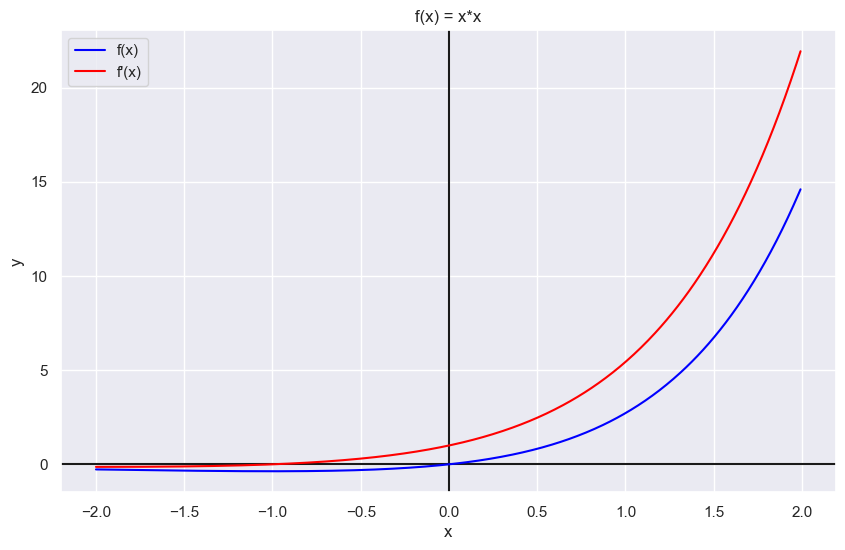

In [11]:
draw(f, fs, -2, 2, 'f(x) = x*x')

We try a function that is slightly more complicated next.
The function `S` implements the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), which is defined as
$$ \texttt{S}(x) = \frac{1}{1 + \mathrm{e}^{-x}}. $$

In [ ]:
def S(x):
    return 1.0 / (1.0 + np.exp(-x))

The function `S_prime` computes the [derivative](https://en.wikipedia.org/wiki/Derivative) of the Sigmoid function.  We implement it using *automatic differentiation*.  This is the closest thing to magic I have seen yet.

In [ ]:
S_prime = ag.grad(S)

Next, we plot both the sigmoid function and its derivative.

In [ ]:
draw(S, S_prime, -6, 6, 'f(x) = 1/(1 + exp(-x))')

The cool thing about `autograd` is that it can take the derivative of <u>any</u> Python function, provided this function is differentiable.
For example, the function `mySqrt(x)` computes the square root of `x` using [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method).
It defines the sequence $(r_n)_{n\in\mathbb{N}}$ as
- $\displaystyle r_0 = \frac{ 1}{2} \cdot x$ and
- $\displaystyle r_{n+1} = \frac{1}{2} \cdot \Bigl(r_n + \frac{x}{r_n}\Bigr)$.

This sequence converges quadratically to the square root of $x$:
$$ \lim\limits_{n\rightarrow\infty} r_n = \sqrt{x} $$

In [ ]:
def mySqrt(x): 
    root = x
    eps  = 2.0e-15
    while abs(x - root * root) > eps:
        root = 0.5 * (root + x / root)    
    return root

In [ ]:
mySqrtGrad = ag.grad(mySqrt)

As we have
$$ \frac{\mathrm{d}\; }{\mathrm{d} x}\sqrt{x} = \frac{1}{2} \cdot \frac{1}{\sqrt{x}}, $$
the derivative is undefined for $x=0$.  Hence we draw the function for $x \geq 0.05$.

In [ ]:
draw(mySqrt, mySqrtGrad, 0.05, 4, 'f(x) = sqrt(x)')

Unfortunately, `autograd` has its limitations, as shown by the next cell.

In [ ]:
mySqrtGrad(1.0)

The reason for this bug is that when `mySqrt` is called with the argument `1.0`, it just returns the value `x`, since the `while` loop is never executed because the condition `abs(x - root * root) > eps` is `False`.  If we rewrite the function `mySqrt` so that the body of the `while` loop is executed at least once, then the problem disapears.

In [ ]:
def mySqrt(x): 
    root = x
    eps  = 2.0e-15
    while True:
        root = 0.5 * (root + x / root)
        if abs(x - root * root) < eps:
            return root

In [ ]:
mySqrtGrad = ag.grad(mySqrt)

In [ ]:
mySqrtGrad(1.0)

## Implementing Newton's Method with `autograd`

[Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) for solving an equation of the form
$$  f(x) = 0 $$
defines a sequence $(x_n)_{n\in\mathbb{N}}$ inductively:
* $x_0 = 1.0$
* $x_{n+1} = x_n - \frac{\displaystyle f(x_n)}{\displaystyle f'(x_n)}$  
 
Then, if the function $f$ is convex, twice differentiable, and has a change of sign, then the limit 
$$ \bar{x} = \lim\limits_{n\rightarrow\infty} x_n $$
satisfies $f(\bar{x}) = 0$.

The function `newton` takes a function `f` and computes the 
value `x` such that $f(x) = 0$ using Newton's method.  Note that it uses the `grad` function to compute
the derivative of `f`:

In [ ]:
def newton(f):
    fs  = ag.grad(f)
    x   = 1.0 
    eps = 1.0e-14
    while True:
        x = x - f(x) / fs(x)
        if abs(f(x)) <= eps:
            return x

We proceed to solve the equation
$$ \cos(x) - x = 0. $$
To this end we define the function $f(x) = \cos(x) - x$.

In [ ]:
def f(x): 
    return np.cos(x) - x

In [ ]:
draw(f, ag.grad(f), 0.0, 1.5, 'f(x) = cos(x) - x')

Let us find the root of this function.

In [ ]:
x = newton(f)
x

In [ ]:
f(x)